# Kaggle Novice to Grandmaster
### Competition #1: Titanic - Machine Learning from Disaster
- https://www.kaggle.com/c/titanic




In [ ]:
# import tensorflow as tf

# from tensorflow import feature_column
# from tensorflow.keras import layers

# # df to tf.data
# def df_to_dataset(dataframe, shuffle=True, batch_size=32):
#   dataframe = dataframe.copy()
#   labels = dataframe.pop('Survived')
#   ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
#   if shuffle:
#     ds = ds.shuffle(buffer_size=len(dataframe))
#   ds = ds.batch(batch_size)
#   return ds

# batch_size = 5
# train_ds = df_to_dataset(train_df, batch_size=batch_size)
# test_ds = df_to_dataset(test_df, shuffle=False, batch_size=batch_size)

In [332]:
# Packages
import os

import pandas as pd
import numpy as np
import random
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

!pip install -q kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = 'kangbeenko'
os.environ['KAGGLE_KEY'] = '7bf5875a0067e432fb8a9300acd60b8e'

In [333]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import accuracy_score

## Dataset

In [334]:
!kaggle competitions download -c titanic

gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [335]:
train_df=pd.read_csv("./train.csv")
test_df=pd.read_csv("./test.csv")

## 01. EDA

In [336]:
# feature 확인
print(train_df.columns)
train_df.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- PassengerId : 각 승객의 고유 번호

- Survived : 생존 여부(종속 변수)

  > 0 = 사망 / 1 = 생존

- Pclass : 객실 등급 - 승객의 사회적, 경제적 지위

  > 1st = Upper / 2nd = Middle / 3rd = Lower

- Name : 이름

- Sex : 성별

- Age : 나이

- SibSp : 동반한 Sibling(형제자매)와 Spouse(배우자)의 수

- Parch : 동반한 Parent(부모) Child(자식)의 수

- Ticket : 티켓의 고유넘버

- Fare : 티켓의 요금

- Cabin : 객실 번호

- Embarked : 승선한 항

  > C = Cherbourg / Q = Queenstown / S = Southampton

In [337]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [338]:
train_df['Initial']=0
for i in train_df:
    train_df['Initial']=train_df.Name.str.extract('([A-Za-z]+)\.')
print(train_df['Initial'])
print(train_df['Name'])

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Initial, Length: 891, dtype: object
0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object


In [339]:
pd.crosstab(train_df.Initial, train_df.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [340]:
train_df['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Dr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
pd.crosstab(train_df.Initial,train_df.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Dr,Master,Miss,Mr,Mrs,Other
Sex,,,,,,
female,1,0,186,0,127,0
male,6,40,0,522,0,9


In [341]:
train_df.sample()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial
32,33,1,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.75,NaN,Q,Miss


In [342]:
train_df.groupby('Initial')['Age'].mean()

Initial
Dr        42.000000
Master     4.574167
Miss      21.860000
Mr        32.601737
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

In [343]:
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Mr'),'Age']=33
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Mrs'),'Age']=36
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Miss'),'Age']=22
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Master'),'Age']=5
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Dr'),'Age']=42
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Other'),'Age']=46

In [344]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [345]:
test_df['Initial']=0
for i in test_df:
    test_df['Initial']=test_df.Name.str.extract('([A-Za-z]+)\.')
pd.crosstab(test_df.Initial, test_df.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Col,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
Sex,,,,,,,,,
female,0,1,0,0,78,0,72,1,0
male,2,0,1,21,0,240,0,0,2


In [346]:
test_df['Initial'].replace(['Col','Dona','Dr','Master','Miss','Mr','Mrs','Ms','Rev'],['Other','Mrs','Dr','Master','Miss','Mr','Mrs','Miss','Other'],inplace=True)
pd.crosstab(test_df.Initial,test_df.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Dr,Master,Miss,Mr,Mrs,Other
Sex,,,,,,
female,0,0,79,0,73,0
male,1,21,0,240,0,4


In [347]:
test_df.groupby('Initial')['Age'].mean()

Initial
Dr        53.000000
Master     7.406471
Miss      21.774844
Mr        32.000000
Mrs       38.904762
Other     42.750000
Name: Age, dtype: float64

In [348]:
test_df.loc[(test_df.Age.isnull())&(test_df.Initial=='Mr'),'Age']=32
test_df.loc[(test_df.Age.isnull())&(test_df.Initial=='Mrs'),'Age']=39
test_df.loc[(test_df.Age.isnull())&(test_df.Initial=='Miss'),'Age']=22
test_df.loc[(test_df.Age.isnull())&(test_df.Initial=='Master'),'Age']=7
test_df.loc[(test_df.Age.isnull())&(test_df.Initial=='Dr'),'Age']=53
test_df.loc[(test_df.Age.isnull())&(test_df.Initial=='Other'),'Age']=43

In [349]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.852043,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.287350,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [350]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked,Initial
count,891,891,891,204,889,891
unique,891,2,681,147,3,6
top,"Sandstrom, Miss. Marguerite Rut",male,1601,C23 C25 C27,S,Mr
freq,1,577,7,4,644,522


In [351]:
train_df.describe(include=np.number)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.852043,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.287350,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 객실 등급별 생존율

In [352]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


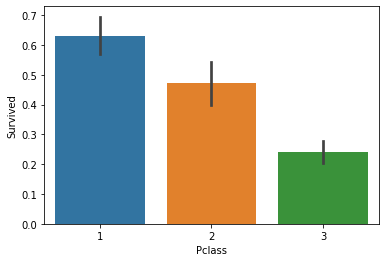

In [353]:
sns.barplot('Pclass','Survived',data=train_df)
plt.show()

객실 등급이 높을수록 생존율 높음

### 성별 기준 생존율

In [354]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


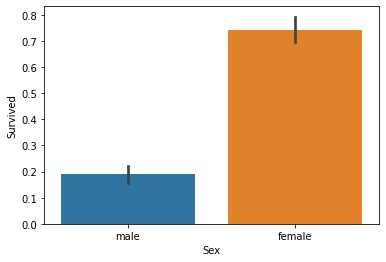

In [355]:
sns.barplot('Sex','Survived',data=train_df)
plt.show()

여성 생존율이 남성에 비해 월등히 높음

### 동승 형제자매 수에 따른 생존율

In [356]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


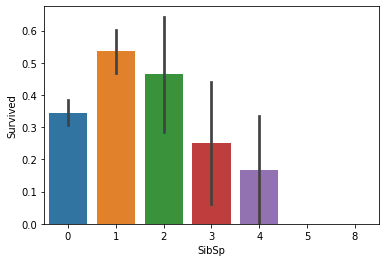

In [357]:
sns.barplot('SibSp','Survived',data=train_df)
plt.show()

동승 형제자매는 적을수록 생존율이 올라가는 추세를 보이나, 아예 0명인 경우 중간 정도의 생존율을 보인다

### 동승 자녀 수에 따른 생존율

In [358]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


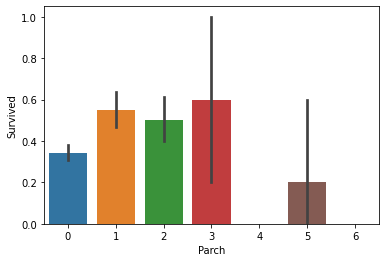

In [359]:
sns.barplot('Parch','Survived',data=train_df)
plt.show()

자녀가 3명일 때 가장 생존율이 높고, 1명, 2명, 0명, 5명 순으로 낮아진다

### 승선지별 생존율

In [360]:
train_df[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


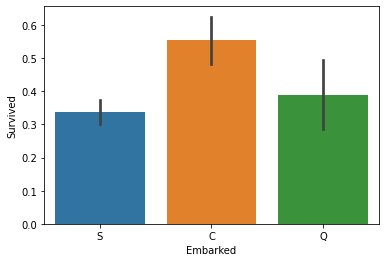

In [361]:
sns.barplot('Embarked','Survived',data=train_df)
plt.show()

Cherbourg에서 탄 승객이 생존율이 높음

In [362]:
train_df[["Embarked", "Pclass"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Pclass', ascending=False)

,Embarked,Pclass
1,Q,2.909091
2,S,2.350932
0,C,1.886905


C에서 탄 사람들 평균 객실 등급이 높음. 다만 Q 승선 승객의 객실 평균 등급이 S보다 낮음에도 불구하고 S보다 생존율이 높은 것이 흥미로움

S에 탑승한 사람들이 대부분 음악가와 군인

### 나이별 생존율

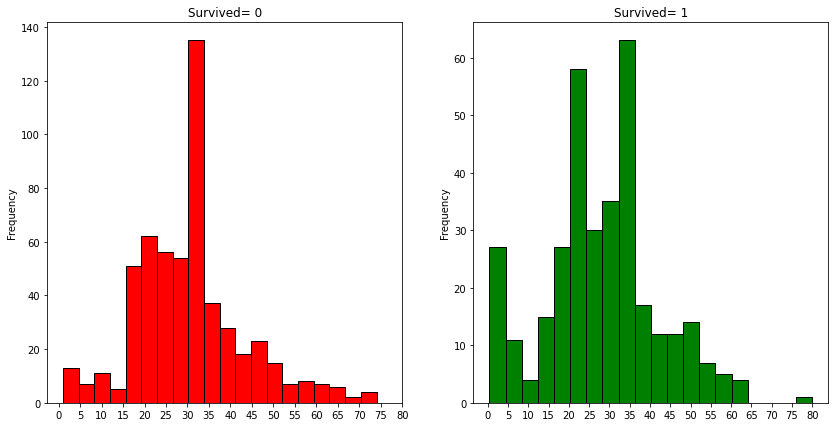

In [363]:
f,ax=plt.subplots(1,2,figsize=(14,7))
train_df[train_df['Survived']==0].Age.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
train_df[train_df['Survived']==1].Age.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

사망자는 30대가 가장 많았고, 생존자는 2,30대가 많다

### 다중 조건

#### 나이X객실 등급별 생존율

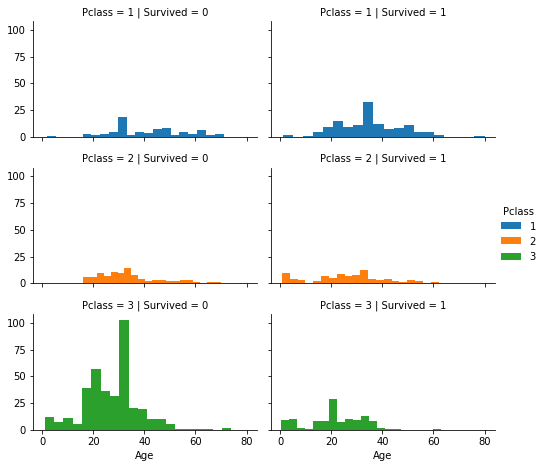

In [364]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', hue="Pclass", height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend()

#### 나이X성별에 땨른 생존율

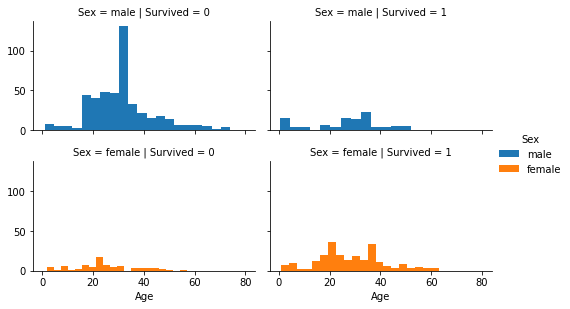

In [365]:
grid = sns.FacetGrid(train_df, col='Survived', row='Sex', hue="Sex", height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend()

#### 승선지X성별X객실 등급별 생존율

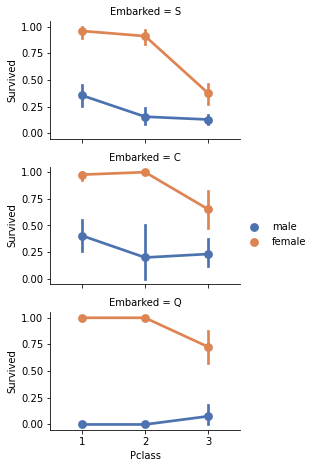

In [366]:
grid = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order = [1, 2, 3], hue_order = ["male", "female"])

grid.add_legend()

## 02. Feature Engineering & Selection

In [367]:
combine = [train_df, test_df]

In [368]:
for dataset in combine:
  dataset.drop(['Name', 'PassengerId', 'Ticket', 'Cabin', 'Initial'], axis=1, inplace=True)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [369]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S


In [370]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 10, 'Bucketized_Age'] = 0
    dataset.loc[(dataset['Age'] > 10) & (dataset['Age'] <= 20), 'Bucketized_Age'] = 1
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 30), 'Bucketized_Age'] = 2
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 40), 'Bucketized_Age'] = 3
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 50), 'Bucketized_Age'] = 4
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 60), 'Bucketized_Age'] = 5
    dataset.loc[(dataset['Age'] > 60) & (dataset['Age'] <= 70), 'Bucketized_Age'] = 6
    dataset.loc[ dataset['Age'] > 70, 'Bucketized_Age'] = 7
    dataset.drop(['Age'], axis=1, inplace=True)
train_df.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Bucketized_Age
0,0,3,0,1,0,7.2500,S,2.0
1,1,1,1,1,0,71.2833,C,3.0
2,1,3,1,0,0,7.9250,S,2.0
3,1,1,1,1,0,53.1000,S,3.0
4,0,3,0,0,0,8.0500,S,3.0


In [371]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset.drop(['SibSp', 'Parch'], axis=1, inplace=True)

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [372]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [373]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [374]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

In [375]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'Q': 1, 'C': 2} ).astype(int)

In [376]:
train_df.groupby('Pclass')['Fare'].mean()

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

In [377]:
train_df.loc[(train_df.Fare.isnull())&(train_df.Pclass==1),'Fare']=84
train_df.loc[(train_df.Fare.isnull())&(train_df.Pclass==2),'Fare']=21
train_df.loc[(train_df.Fare.isnull())&(train_df.Pclass==3),'Fare']=14

In [378]:
test_df.groupby('Pclass')['Fare'].mean()

Pclass
1    94.280297
2    22.202104
3    12.459678
Name: Fare, dtype: float64

In [379]:
test_df.loc[(test_df.Fare.isnull())&(test_df.Pclass==1),'Fare']=94
test_df.loc[(test_df.Fare.isnull())&(test_df.Pclass==2),'Fare']=22
test_df.loc[(test_df.Fare.isnull())&(test_df.Pclass==3),'Fare']=12

In [380]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [381]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df.drop(['FareBand'], axis=1, inplace=True)
combine = [train_df, test_df]

## 03. Prepare Data

In [382]:
print(train_df.shape)
print(test_df.shape)

(891, 8)
(418, 7)


In [384]:
train_df.isnull().sum()

Survived          0
Pclass            0
Sex               0
Fare              0
Embarked          0
Bucketized_Age    0
FamilySize        0
IsAlone           0
dtype: int64

In [385]:
X_train = train_df.drop("Survived", axis=1)
#목적 변수 역할
y_train = train_df["Survived"]
#예측 대상 데이터 셋
X_test  = test_df.copy()

## 04. Models

### 4-1. Logistic Regression

In [451]:
params = {
    'max_iter': [100, 200, 300, 400, 500],
    'C': [1,3,5,7,9]
}

In [452]:
model = LogisticRegression()
grid_model = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid_model.fit(X_train, y_train)

print('best parameters : ', grid_model.best_params_)
print('best score : ', grid_model.best_score_)

acc_lr = grid_model.best_score_

best parameters :  {'C': 1, 'max_iter': 100}
best score :  0.787878787878788


### 4-2. SVC

In [397]:
params = {
    'C': [1,3,5,7,9],
    'kernel': ['linear', 'rbf', 'poly']
}

In [453]:
model = SVC()
grid_model = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid_model.fit(X_train, y_train)

print('best parameters : ', grid_model.best_params_)
print('best score : ', grid_model.best_score_)

acc_svc = grid_model.best_score_

best parameters :  {'C': 3, 'max_iter': 200}
best score :  0.829405162738496


### 4-3. LinearSVC

In [454]:
params = {
    'C': [1,3,5,7,9],
    'loss': ['hinge','squared_hinge']
}

In [456]:
model = LinearSVC()
grid_model = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid_model.fit(X_train, y_train)

print('best parameters : ', grid_model.best_params_)
print('best score : ', grid_model.best_score_)

acc_linearsvc = grid_model.best_score_

best parameters :  {'C': 9, 'loss': 'squared_hinge'}
best score :  0.7979797979797979


### 4-4. k-NN

In [457]:
params = {
    'n_neighbors' : list(range(1,20)),
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

In [459]:
model = KNeighborsClassifier()
grid_model = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid_model.fit(X_train, y_train)

print('best parameters : ', grid_model.best_params_)
print('best score : ', grid_model.best_score_)

acc_knn = grid_model.best_score_

best parameters :  {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
best score :  0.8114478114478114


### 4-5. Gaussian NB

In [460]:
params = {
    'var_smoothing': np.logspace(0,-9, num=100)
    }

In [462]:
model = GaussianNB()
grid_model = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid_model.fit(X_train, y_train)

print('best parameters : ', grid_model.best_params_)
print('best score : ', grid_model.best_score_)

acc_gnb = grid_model.best_score_

best parameters :  {'var_smoothing': 0.01873817422860384}
best score :  0.7687991021324354


### 4-6. Perceptron

In [463]:
params = {
    'alpha': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05],
    'early_stopping': [True, False]
}

In [464]:
model = Perceptron()
grid_model = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid_model.fit(X_train, y_train)

print('best parameters : ', grid_model.best_params_)
print('best score : ', grid_model.best_score_)

acc_perceptron = grid_model.best_score_

best parameters :  {'alpha': 1e-10, 'early_stopping': True}
best score :  0.7890011223344556


### 4-7. Stochastic Gradient Descent

In [465]:
params = {
  'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
  'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

In [466]:
model = SGDClassifier()
grid_model = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid_model.fit(X_train, y_train)

print('best parameters : ', grid_model.best_params_)
print('best score : ', grid_model.best_score_)

acc_sgd = grid_model.best_score_

best parameters :  {'learning_rate': 'optimal', 'loss': 'hinge'}
best score :  0.7373737373737373


### 4-8. Decision Tree

In [467]:
params = {
    'criterion': ['gini','entropy'],
    'splitter': ['best','random'],
    'max_depth': [1,3,5,7,9,11],
}

In [468]:
model = DecisionTreeClassifier()
grid_model = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid_model.fit(X_train, y_train)

print('best parameters : ', grid_model.best_params_)
print('best score : ', grid_model.best_score_)

acc_dt = grid_model.best_score_

best parameters :  {'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}
best score :  0.8181818181818182


### 4-9. RandomForest

In [469]:
params = {
    'n_estimators': [10, 50, 100, 500],
    'criterion': ['gini','entropy'],
    'bootstrap': [True, False]
}

In [470]:
model = RandomForestClassifier()
grid_model = GridSearchCV(model, param_grid=params, cv=3, refit=True)
grid_model.fit(X_train, y_train)

print('best parameters : ', grid_model.best_params_)
print('best score : ', grid_model.best_score_)

acc_rf = grid_model.best_score_

best parameters :  {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 10}
best score :  0.8080808080808081


## Model Summary

In [471]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_lr, 
              acc_rf, acc_gnb, acc_perceptron, 
              acc_sgd, acc_linearsvc, acc_dt]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Support Vector Machines,0.829405
8,Decision Tree,0.818182
1,KNN,0.811448
3,Random Forest,0.808081
7,Linear SVC,0.797980
5,Perceptron,0.789001
2,Logistic Regression,0.787879
4,Naive Bayes,0.768799
6,Stochastic Gradient Decent,0.737374
